In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import os
import numpy as np
import cv2
import time
import sys
import re
from PIL import Image
from copy import deepcopy
from collections import defaultdict
from itertools import islice
from tqdm import tqdm_notebook
from time import time
from easydict import EasyDict
from IPython.core.debugger import set_trace
from matplotlib import pyplot as plt
from warnings import filterwarnings

import torch
from torch import nn
import torch.nn.functional as F
from torch import autograd
from torch.utils.data import DataLoader
from torchvision.transforms import Resize, ToTensor, Compose


from mvn.utils.img import image_batch_to_numpy, denormalize_image,to_numpy
from mvn.models.pose_hrnet import get_pose_net as get_pose_hrnet
from mvn.models.pose_resnet import get_pose_net as get_pose_resnet

from mvn.utils.multiview import project_3d_points_to_image_plane_without_distortion
from mvn.utils.vis import draw_2d_pose
from mvn.utils import img
from mvn.utils import multiview
from mvn.utils import volumetric
from mvn.utils import op
from mvn.utils import vis
from mvn.utils import misc
from mvn.utils import cfg
from mvn.datasets import utils as dataset_utils
from mvn.datasets.human36m import Human36MMultiViewDataset, Human36MTemporalDataset
from mvn.utils.misc import get_start_stop_frame_indxs, index_to_name, get_error_diffs, normalize_temporal_images_batch, retval, get_capacity

from train import setup_human36m_dataloaders

from mvn.models.triangulation import VolumetricTriangulationNet
from mvn.models.volumetric_adain import VolumetricTemporalAdaINNet
from mvn.models.volumetric_grid import VolumetricTemporalGridDeformation
from mvn.models.volumetric_rnn_spade import VolumetricRNNSpade
from mvn.models.v2v import V2VModel, SPADE
from mvn.models.s2s import S2SModel

from mvn.models.loss import KeypointsMSELoss, \
                            KeypointsMSESmoothLoss, \
                            KeypointsMAELoss, \
                            KeypointsL2Loss, \
                            VolumetricCELoss,\
                            GAN_loss,\
                            LSGAN_loss

from IPython.core.debugger import set_trace
from IPython.display import clear_output


%matplotlib inline

collate_fn = dataset_utils.make_collate_fn(randomize_n_views=False,
                                           min_n_views=None,
                                           max_n_views=None)

device = 'cuda:0' #torch.cuda.current_device()
print ('Done')
# torch.backends.cudnn.benchmark = True
# torch.backends.cudnn.enabled = True 

Done


In [ ]:
if self.pivot_type == 'intermediate':
assert self.dilation_type == 'constant'
iterator=range(-((self._time_period)//2), ((self._time_period)//2)+1, self.dilation+1)
elif self.pivot_type == 'first':
iterator={'constant':range(-(self._time_period-1), 1, self.dilation+1),
          'custom': self.custom_iterator,  
          'square':np.concatenate([[0], \
                   -(np.arange(self.dilation, self.dilation+self.dt-1)**2).astype(int)])[::-1]
          }[self.dilation_type]

In [2]:
def plot_stuff(metric_dicts, index):
    fig, axes = plt.subplots(ncols = 3, nrows=1, figsize=(20,7))
    for name, metric_dict in metric_dicts.items():
        axes[0].plot(metric_dict['total_loss'], alpha=0.5, label=name)
        axes[0].set_title('total_loss')

        axes[1].plot(metric_dict[f'{config.opt.criterion}'], alpha=0.5, label=name)
        axes[1].set_title('criterion loss')

        axes[2].plot(metric_dict['volumetric_ce_loss'], alpha=0.5, label=name)
        axes[2].set_title(f'volumetric_ce_loss: {config.opt.volumetric_ce_loss_weight}')
        
#         if 'total_loss_epoch' in metric_dict.keys():
#         axes[1,0].plot(metric_dict['total_loss_epoch'], alpha=0.5, label=name)
#         axes[1,0].set_title('total_loss_epoch')
#         axes[1,1].plot(metric_dict[f'{config.opt.criterion}_epoch'], alpha=0.5, label=name)
#         axes[1,1].set_title('criterion loss_epoch')
#         axes[1,2].plot(metric_dict['volumetric_ce_loss_epoch'], alpha=0.5, label=name)
#         axes[1,2].set_title(f'volumetric_ce_loss_epoch')
        
    plt.tight_layout()
    plt.show()

In [3]:
config_path = './experiments/human36m/train/human36m_s2s.yaml'

config = cfg.load_config(config_path)
config.dataset.val.retain_every_n_frames_in_test = 1

train_dataloader, val_loader, _ = setup_human36m_dataloaders(config,
                                                             is_train=True,
                                                             distributed_train=False)

batch_size, dt, dilation = val_loader.batch_size, val_loader.dataset.dt, val_loader.dataset.dilation

pivot_type = config.dataset.pivot_type 
keypoints_per_frame = config.dataset.keypoints_per_frame if hasattr(config.dataset, 'keypoints_per_frame') else False
pivot_position = {'first':-1, 'intermediate':dt//2}[pivot_type]

if not hasattr(config.model.backbone, 'group_norm'):
    config.model.backbone.group_norm = False

print('Batch size:', batch_size, '\n',\
      'dt:', dt, '\n',\
      'dilation:', dilation, '\n',\
      'pivot_type:', pivot_type, '\n',\
      'pivot_position:', pivot_position,'\n',\
      'keypoints_per_frame', keypoints_per_frame)


Batch size: 4 
 dt: 6 
 dilation: 1 
 pivot_type: first 
 pivot_position: -1 
 keypoints_per_frame False


# Model

In [4]:
model = S2SModel(config, device=device).to(device)
print ('Loaded {} model'.format(config.model.name))

opt = torch.optim.Adam([] +\
                ([{'params':model.backbone.parameters(), \
                            'lr': config.opt.backbone_lr if \
                            hasattr(config.opt, "backbone_lr") else config.opt.lr}] if \
                            hasattr(model, 'backbone') else []) + \
                ([{'params': model.encoder.parameters(), \
                            'lr': config.opt.encoder_lr if \
                            hasattr(config.opt, "encoder_lr") else config.opt.lr}] if \
                            hasattr(model, 'encoder') else []) + \
                ([{'params': model.style_to_volumes.parameters(), \
                            'lr': config.opt.style_to_volumes_lr if \
                            hasattr(config.opt, "style_to_volumes_lr") else config.opt.lr}] if \
                            hasattr(model, 'style_to_volumes') else []) + \
                ([{'params': model.features_sequence_to_vector.parameters(), \
                            'lr': config.opt.features_sequence_to_vector_lr if \
                            hasattr(config.opt, "features_sequence_to_vector_lr") else config.opt.lr}] if \
                            hasattr(model, "features_sequence_to_vector") else []),
                lr=config.opt.lr)

R2D inited by ./data/r2plus1d_34_clip8_ig65m_from_scratch-9bae36ae.pth
features_sequence_to_vector:  24.43M
style_to_volumes:  0.0M
Loaded s2s model


In [5]:
old_metric_dict = np.load('metric_dict_e3dlstm.npy', allow_pickle=True).item()

# Train

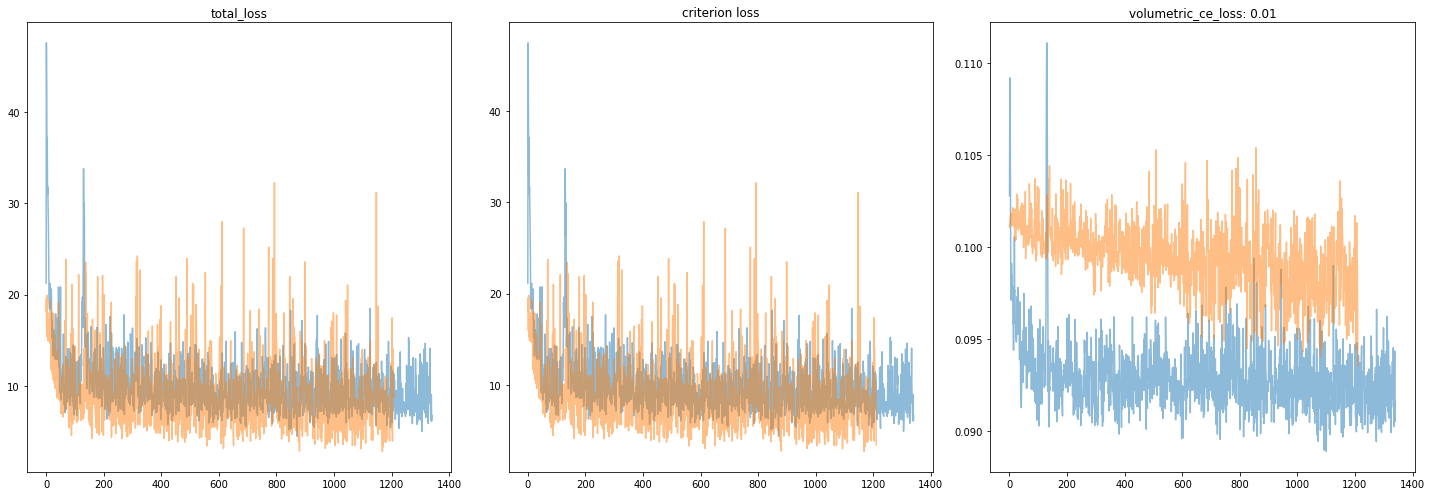

KeyboardInterrupt: 

In [6]:
criterion = KeypointsMAELoss()
dataloader = train_dataloader
n_iters_total=0
is_train=True
caption=''
master=False
experiment_dir=None
writer=None
discriminator=None
opt_discr=None
epochs = 10

name = "train" if is_train else "val"
model_type = config.model.name
silence = config.opt.silence if hasattr(config.opt, 'silence') else False

singleview_dataset = config.dataset.singleview if hasattr(config.dataset, 'singleview') else False
pivot_type = config.dataset.pivot_type
pivot_index =  {'first':config.dataset.dt-1,
                'intermediate':config.dataset.dt//2}[pivot_type]

scale_keypoints_3d = config.opt.scale_keypoints_3d if hasattr(config.opt, "scale_keypoints_3d") else 1.0    
transfer_cmu_to_human36m = config.transfer_cmu_to_human36m if hasattr(config, "transfer_cmu_to_human36m") else False

N = config.opt.n_objects_per_epoch

if is_train:
    model.train()
else:
    model.eval()

metric_dict = defaultdict(list)
for epoch in range(epochs):
    # used to turn on/off gradients
    grad_context = torch.autograd.enable_grad if is_train else torch.no_grad
    with grad_context():

        iterator = enumerate(dataloader)
        iterator = islice(iterator, N)

        for iter_i, batch in tqdm_notebook(iterator):
            with autograd.detect_anomaly():
                if batch is None:
                    print("Found None batch at iter {}, continue...".format(iter_i))
                    continue 

                debug = False    
                (images_batch, 
                keypoints_3d_gt, 
                keypoints_3d_validity_gt, 
                proj_matricies_batch) = dataset_utils.prepare_batch(batch, device)

                heatmaps_pred, keypoints_2d_pred, cuboids_pred, base_points_pred = None, None, None, None
                torch.cuda.empty_cache()

                (keypoints_3d_pred, 
                volumes_pred, 
                coord_volumes_pred,
                base_points_pred) = model(images_batch, batch)            
                
                if keypoints_per_frame:
                    keypoints_3d_gt = keypoints_3d_gt[:,-1]
                    keypoints_3d_validity_gt = keypoints_3d_validity_gt[:,-1]
                
                batch_size, dt = images_batch.shape[:2]
                keypoints_3d_binary_validity_gt = (keypoints_3d_validity_gt > 0.0).type(torch.float32)
                keypoints_shape = keypoints_3d_gt.shape[-2:]
                
                ################
                # MODEL OUTPUT #   
                ################
                if singleview_dataset:
                    coord_volumes_pred = coord_volumes_pred - base_points_pred.unsqueeze(1).unsqueeze(1).unsqueeze(1)
                    keypoints_3d_gt = op.root_centering(keypoints_3d_gt, config.kind)
                    keypoints_3d_pred = op.root_centering(keypoints_3d_pred, config.kind)

                ##################
                # CALCULATE LOSS #   
                ##################
                # MSE\MAE loss
                total_loss = 0.0
                loss = criterion((keypoints_3d_pred  - keypoints_3d_gt)*scale_keypoints_3d,keypoints_3d_binary_validity_gt)
                total_loss += loss
                metric_dict[f'{config.opt.criterion}'].append(loss.item())
                # volumetric loss
                use_volumetric_ce_loss = config.opt.use_volumetric_ce_loss
                if use_volumetric_ce_loss:
                    volumetric_ce_criterion = VolumetricCELoss()
                    loss = volumetric_ce_criterion(coord_volumes_pred, 
                                                    volumes_pred, 
                                                    keypoints_3d_gt, 
                                                    keypoints_3d_binary_validity_gt)
                    weight = config.opt.volumetric_ce_loss_weight
                    total_loss += weight * loss
                    metric_dict['volumetric_ce_loss'].append(weight*loss.item())

                ############
                # BACKWARD #   
                ############
                if is_train:
                    opt.zero_grad()
                    total_loss.backward()        
                    if hasattr(config.opt, "grad_clip"):
                        torch.nn.utils.clip_grad_norm_(model.parameters(), config.opt.grad_clip / config.opt.lr)

                    opt.step()
                metric_dict['total_loss'].append(total_loss.item())

                ########
                # PLOT #
                ########
                if iter_i%5 == 0:
                    clear_output()
                    plot_stuff({'v2v':metric_dict, 'e3dlstm':old_metric_dict}, iter_i)
                    
    # end of the epoch
    for title, value in metric_dict.items():
        metric_dict[f"{title}_epoch"] = np.mean(value[-N:])
        

In [7]:
# np.save(f'metric_dict_r2d', metric_dict)

In [26]:
s = model.features_sequence_to_vector.state_dict()
print (s['final_layer.0.bias'])
s['final_layer.0.bias'] = torch.zeros_like(s['final_layer.0.bias'])

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


In [27]:
s['final_layer.0.bias']

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')

In [28]:
model.features_sequence_to_vector.load_state_dict(s, strict=True)

<All keys matched successfully>

In [29]:
model.features_sequence_to_vector.state_dict()['final_layer.0.bias']

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')